 ## Fast optimization of SVR hyperparameters with Gaussian kernel

Hiromasa Kaneko

In [1]:
import numpy as np
#import pandas as pd
from sklearn import model_selection, svm, datasets
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import matplotlib.figure as figure
import time

In [2]:
# Settings
svrcs = 2**np.arange( -5, 11, dtype=float)          # Candidates of C
svrepsilons = 2**np.arange( -10, 1, dtype=float)    # Candidates of epsilon
svrgammas = 2**np.arange( -20, 11, dtype=float)     # Candidates of gamma
foldnumber = 5 # "foldnumber"-fold cross-validation
nmberoftrainingsamples = 1000
nmberoftestsamples = 1000

In [3]:
# Generate samples for demonstration
X, y = datasets.make_regression(n_samples=nmberoftrainingsamples+nmberoftestsamples, n_features=100,
                                n_informative=100, noise=100, random_state=0)

In [4]:
# Divide samples into trainign samples and test samples
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=nmberoftestsamples, random_state=0)

In [5]:
# Standarize X and y
autoscaledXtrain = (Xtrain - Xtrain.mean(axis=0)) / Xtrain.std(axis=0, ddof=1)
autoscaledytrain = (ytrain - ytrain.mean()) / ytrain.std(ddof=1)
autoscaledXtest =  (Xtest - Xtrain.mean(axis=0)) / Xtrain.std(axis=0, ddof=1)

In [6]:
# Measure time in hyperparameter optimization
starttime = time.time()

In [7]:
# Optimize gamma by maximizing variance in Gram matrix
numpyautoscaledXtrain = np.array(autoscaledXtrain)
varianceofgrammatrix = list()
for svrgamma in svrgammas:
    grammatrix = np.exp(-svrgamma*((numpyautoscaledXtrain[:, np.newaxis] - numpyautoscaledXtrain)**2).sum(axis=2))
    varianceofgrammatrix.append(grammatrix.var(ddof=1))
optimalsvrgamma = svrgammas[ np.where( varianceofgrammatrix == np.max(varianceofgrammatrix) )[0][0] ]

In [8]:
# Optimize epsilon with cross-validation
svrmodelincv = GridSearchCV(svm.SVR(kernel='rbf', C=3, gamma=optimalsvrgamma), {'epsilon':svrepsilons}, cv=foldnumber )
svrmodelincv.fit(autoscaledXtrain, autoscaledytrain)
optimalsvrepsilon = svrmodelincv.best_params_['epsilon']

In [9]:
# Optimize C with cross-validation
svrmodelincv = GridSearchCV(svm.SVR(kernel='rbf', epsilon=optimalsvrepsilon, gamma=optimalsvrgamma), {'C':svrcs}, cv=foldnumber )
svrmodelincv.fit(autoscaledXtrain, autoscaledytrain)
optimalsvrc = svrmodelincv.best_params_['C']

In [10]:
# Optimize gamma with cross-validation (optional)
svrmodelincv = GridSearchCV(svm.SVR(kernel='rbf', epsilon=optimalsvrepsilon, C=optimalsvrc), {'gamma':svrgammas}, cv=foldnumber )
svrmodelincv.fit(autoscaledXtrain, autoscaledytrain)
optimalsvrgamma = svrmodelincv.best_params_['gamma']

In [11]:
# Check time in hyperparameter optimization
elapsedtime = time.time() - starttime
print ("Elapsed time in hyperparameter optimization: {0} [sec]".format(elapsedtime))

Elapsed time in hyperparameter optimization: 86.29207825660706 [sec]


In [12]:
# Check optimized hyperparameters
print ("C: {0}, Epsion: {1}, Gamma: {2}".format(optimalsvrc, optimalsvrepsilon, optimalsvrgamma))

C: 4.0, Epsion: 0.015625, Gamma: 0.0009765625


In [13]:
# Construct SVR model
regressionmodel = svm.SVR(kernel='rbf', C=optimalsvrc, epsilon=optimalsvrepsilon, gamma=optimalsvrgamma)
regressionmodel.fit(autoscaledXtrain, autoscaledytrain)

SVR(C=4.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.015625,
  gamma=0.0009765625, kernel='rbf', max_iter=-1, shrinking=True, tol=0.001,
  verbose=False)

In [14]:
# Calculate y of trainig dataset
calculatedytrain = np.ndarray.flatten( regressionmodel.predict(autoscaledXtrain) )
calculatedytrain = calculatedytrain*ytrain.std(ddof=1) + ytrain.mean()

In [15]:
# r2, RMSE, MAE
print( "r2: {0}".format(float( 1 - sum( (ytrain-calculatedytrain )**2 ) / sum((ytrain-ytrain.mean())**2) )) )
print( "RMSE: {0}".format(float( ( sum( (ytrain-calculatedytrain)**2 )/ len(ytrain))**0.5 )) )
print( "MAE: {0}".format(float( sum( abs(ytrain-calculatedytrain)) / len(ytrain) )) )

r2: 0.9831924534513368
RMSE: 74.26285959600784
MAE: 49.662182361929084


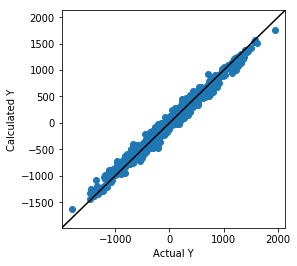

In [16]:
# yyplot
plt.figure(figsize=figure.figaspect(1))
plt.scatter( ytrain, calculatedytrain)
YMax = np.max( np.array([np.array(ytrain), calculatedytrain]))
YMin = np.min( np.array([np.array(ytrain), calculatedytrain]))
plt.plot([YMin-0.05*(YMax-YMin),YMax+0.05*(YMax-YMin)], [YMin-0.05*(YMax-YMin),YMax+0.05*(YMax-YMin)], 'k-')
plt.ylim(YMin-0.05*(YMax-YMin),YMax+0.05*(YMax-YMin))
plt.xlim(YMin-0.05*(YMax-YMin),YMax+0.05*(YMax-YMin))
plt.xlabel("Actual Y")
plt.ylabel("Calculated Y")
plt.show()

In [17]:
# Estimate y in cross-validation
estimatedyincv = np.ndarray.flatten( model_selection.cross_val_predict(regressionmodel, autoscaledXtrain, autoscaledytrain, cv=foldnumber) )
estimatedyincv = estimatedyincv*ytrain.std(ddof=1) + ytrain.mean()

In [18]:
# r2cv, RMSEcv, MAEcv
print( "r2cv: {0}".format(float( 1 - sum( (ytrain-estimatedyincv )**2 ) / sum((ytrain-ytrain.mean())**2) )) )
print( "RMSEcv: {0}".format(float( ( sum( (ytrain-estimatedyincv)**2 )/ len(ytrain))**0.5 )) )
print( "MAEcv: {0}".format(float( sum( abs(ytrain-estimatedyincv)) / len(ytrain) )) )

r2cv: 0.9612749562826922
RMSEcv: 112.72375966704446
MAEcv: 89.67038330386009


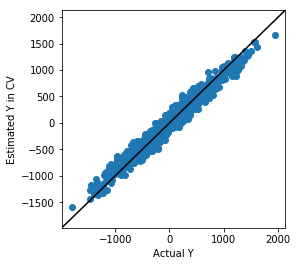

In [19]:
# yyplot
plt.figure(figsize=figure.figaspect(1))
plt.scatter( ytrain, estimatedyincv)
YMax = np.max( np.array([np.array(ytrain), estimatedyincv]))
YMin = np.min( np.array([np.array(ytrain), estimatedyincv]))
plt.plot([YMin-0.05*(YMax-YMin),YMax+0.05*(YMax-YMin)], [YMin-0.05*(YMax-YMin),YMax+0.05*(YMax-YMin)], 'k-')
plt.ylim(YMin-0.05*(YMax-YMin),YMax+0.05*(YMax-YMin))
plt.xlim(YMin-0.05*(YMax-YMin),YMax+0.05*(YMax-YMin))
plt.xlabel("Actual Y")
plt.ylabel("Estimated Y in CV")
plt.show()

In [20]:
# Estimate y of test dataset
predictedytest = np.ndarray.flatten( regressionmodel.predict(autoscaledXtest) )
predictedytest = predictedytest*ytrain.std(ddof=1) + ytrain.mean()

In [21]:
# r2p, RMSEp, MAEp
print( "r2p: {0}".format(float( 1 - sum( (ytest-predictedytest )**2 ) / sum((ytest-ytest.mean())**2) )) )
print( "RMSEp: {0}".format(float( ( sum( (ytest-predictedytest)**2 )/ len(ytest))**0.5 )) )
print( "MAEp: {0}".format(float( sum( abs(ytest-predictedytest)) / len(ytest) )) )

r2p: 0.9611379250872425
RMSEp: 108.75737066499826
MAEp: 85.8076626303417


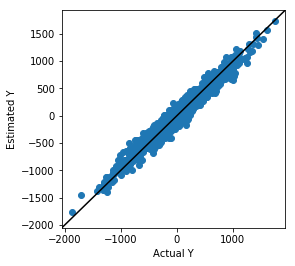

In [22]:
# yyplot
plt.figure(figsize=figure.figaspect(1))
plt.scatter( ytest, predictedytest)
YMax = np.max( np.array([np.array(ytest), predictedytest]))
YMin = np.min( np.array([np.array(ytest), predictedytest]))
plt.plot([YMin-0.05*(YMax-YMin),YMax+0.05*(YMax-YMin)], [YMin-0.05*(YMax-YMin),YMax+0.05*(YMax-YMin)], 'k-')
plt.ylim(YMin-0.05*(YMax-YMin),YMax+0.05*(YMax-YMin))
plt.xlim(YMin-0.05*(YMax-YMin),YMax+0.05*(YMax-YMin))
plt.xlabel("Actual Y")
plt.ylabel("Estimated Y")
plt.show()